### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
import random
from scipy import stats

warnings.filterwarnings('ignore')

In [83]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.decomposition import PCA

### Advanced Classifiers

In [3]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

### Oversampling the Dataset

In [4]:
from imblearn.over_sampling import SMOTE

### Deep learning framework
Firstly you need to install tensorflow to be able to use keras, the deep learning framework. Also make sure that tensorflow version is above 2.2 else you won't be able to use keras. So, things to do before running the below codes:

* pip install tensorflow 
* import tensorflow as tf
* pip install keras 

In [5]:
from keras import models
from keras import layers

### Reading the Data

In [6]:
data_  = pd.read_csv('D:/External Data/GiveMeSomeCredit/cs-training.csv')

In [7]:
data_.columns

Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

### Check the percentage of Defaults and Non-Defaults
It is important to check the Default Rates in case you are creating a scorecard. What is does help in understanding about the data that whether we have a imbalanced data. An imbalanced data is basically where the event rate is really low; in the range of 0-5%. Usually, the defaults are a rare scenarios in case of Home Loans & Auto Loans. When you have a default rate in this range, we should be able to balance the data first and then run any model on the same. To balance a data set, there are a different appraoches but the most common and the one which we will use are:

* SMOTE (Synthetic Minority Over-sampling Technique)
* Near Miss (Under sampling Technique)

Below image clearly explains How Undersampling and Oversampling works:
![Undersampling and Oversampling](SMOTE.png)
Image Source: https://oralytics.com/2019/07/01/managing-imbalanced-data-sets-with-smote-in-python/

**SMOTE** works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

**NEAR MISS** is an under-sampling technique. It aims to balance class distribution by randomly eliminating majority class examples. When instances of two different classes are very close to each other, we remove the instances of the majority class to increase the spaces between the two classes. This helps in the classification process. To prevent problem of information loss in most under-sampling techniques, near-neighbor methods are widely used.

### Checking for the Default rate
As we see that it is definitely a case of imbalanced data. So, we had to follow one of the approach discussed above; so either we will be oversampling or undersampling. There is a trade-off between having to chooses undersampling or oversampling:

1. **With undersampling**, there is a big loss of data as the total number of rows will be reduced to the number of rows for event rate (Defaults). So, there is a high possibility of High Bias,
1. **With oversampling**, there will be synthetic data added to make the Defaults observations equal to the Non-Defaults. The synthetic data is not the exact replica of the observations under Default but these are very much the same as chosen from their nearest neighbours. This can really increase the variance in our model which leads to overfitting. The other disadvantage of oversmapling is that it can increasre the model run time if we are dealing with large number of Non-Defaults

0    93.316
1     6.684
Name: SeriousDlqin2yrs, dtype: float64


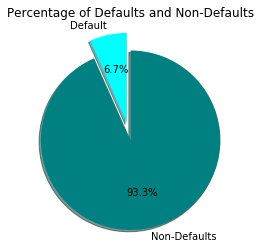

In [8]:
print(data_['SeriousDlqin2yrs'].value_counts()/data_.shape[0] *100)

## Pie Chart
labels = 'Default', 'Non-Defaults'
sizes = [6.684, 93.316]
explode = (0.2, 0)
cols    = ['#00FFFF', '#008080']

fig = plt.figure(figsize = (4,4))
plt.pie(sizes, explode=explode, colors = cols, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')
plt. title("Percentage of Defaults and Non-Defaults")
plt.show()

### Exploratory Data Analysis (EDA)
These will be the steps we will follow before trying to develop any model out of the model:

* Identification of Missing values
* Treatment of Missing values
* Univariate Analysis for all the variables
* Bivariate Analysis
* Correlations

These will help us to strengthen our understanding on the data. We will be knowing about which variables have missing values, outliers if any, the general distribution. Also, we would know about the correlations between the independent and dependent variables.

#### Missing value function

In [9]:
def missing_vals(data_):
    miss_     = data_.isnull().sum()
    miss_pct  = data_.isnull().sum()/data_.shape[0]
    
    miss_pct  = pd.concat([miss_, miss_pct], axis =1)
    miss_pct.reset_index(inplace=True)
    miss_cols = miss_pct.rename(columns={'index':'Column Name', 0:'Missings', 1:'Missing_pct'})
    
    miss_cols = miss_cols[miss_cols.iloc[:,1]!=0].sort_values('Missing_pct', ascending=False).round(1)
    miss_cols.reset_index(inplace=True, drop=True)
    
    return miss_cols    

In [10]:
miss = missing_vals(data_)
miss

,Column Name,Missings,Missing_pct
0,MonthlyIncome,29731,0.2
1,NumberOfDependents,3924,0.0


**Conclusion**: We see that there are very less missing values in two of the columns. Then also, we will be replacing the missing values with mean. Missing value treatment is another area which has so many options but the quickest is replacing it by mean or median (when the missing percentage is really less)

#### Descriptive Statistics
We start with the Descriptive statistics by checking the basic statistics of the variables. Then we start developing histograms for all the variables. These will help us understand the distributions of each of the variable.

In [191]:
data_.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [11]:
cols = list(data_.columns)
cols = cols[1:]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c']

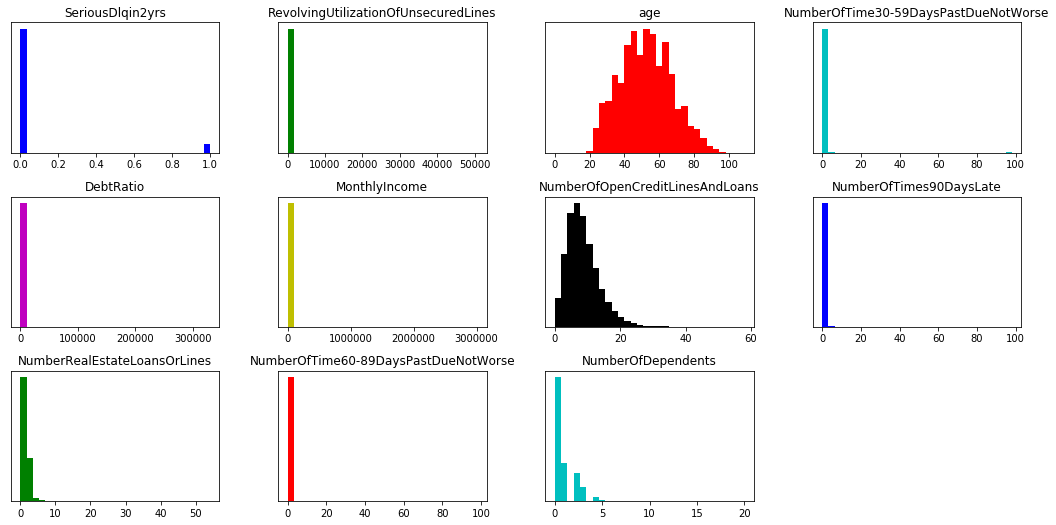

In [12]:
fig = plt.figure(figsize=(15, 12))
for i in range(0, len(cols)):
    plt.subplot(5, 4, i+1)
    f = plt.gca()
    f.axes.get_yaxis().set_visible(False)

    plt.hist(data_[cols[i]], bins=30, color=colors[i])
    plt.title(cols[i])

plt.tight_layout()

#### Replace the missings with the mean

In [14]:
df = data_.copy()
df['MonthlyIncome'] =df['MonthlyIncome'].transform(lambda x: x.fillna(x.mean()))
df['NumberOfDependents'] =df['NumberOfDependents'].transform(lambda x: x.fillna(x.mean()))

#### Check for missing values again

In [15]:
miss = missing_vals(df)
miss

,Column Name,Missings,Missing_pct


As we see that there are no null values left. Many of the Machine Learning algorithms do take missing values in their analysis but it is always a better strategy to treat them before reaching the modelling stage.

There are certain instances when you can't treat them:
1. Missing values take away some 30-50% of observations where you can't delete them
1. In the above case, you can't even treat them with mean, median as a variables with so many similar values doesn't bring a lot of variance in the variable

### Default and Non-Default Visualization
We will try to visualize the Default and Non-Defaults on a 2axis framework and see how much of the overlap they have. For this we will use PCA to get two principal components which are a combination of all the variables. This will help us understand the distribution of Defaults and Non-Defaults

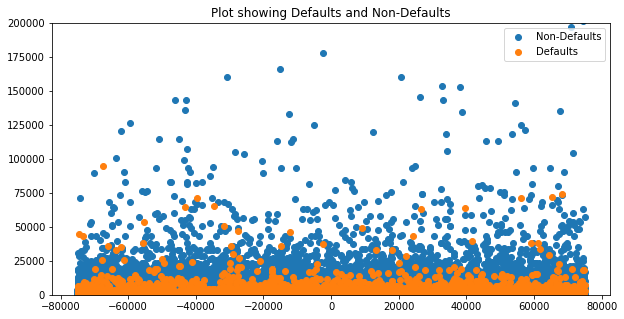

In [16]:
random.seed(32)
pca = PCA(n_components = 2)
pca.fit(df)

scores = pca.transform(df)

x,y = scores[:,0] , scores[:,1]
df_ = pd.DataFrame({'x': x, 'y':y, 'clusters':df['SeriousDlqin2yrs']})
grouping_ = df_.groupby('clusters')


fig, ax = plt.subplots(figsize=(10, 5))
names = {0: 'Non-Defaults', 
         1: 'Defaults'}

for name, grp in grouping_:
    ax.plot(grp.x, grp.y, marker='o', label = names[name], linestyle='')
    ax.set_aspect('auto')
    ax.set_ylim([0,200000])     ### I have just kept a upper cap on the axis to see the distribution of them
    
ax.legend()
plt.title('Plot showing Defaults and Non-Defaults')
plt.show()

### Now doing the one-hot encoding
One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction

Some algorithms can work with categorical data directly. For example, a decision tree can be learned directly from categorical data with no data transform required (this depends on the specific implementation). Many machine learning algorithms cannot operate on label data directly. They require all input variables and output variables to be numeric. In general, this is mostly a constraint of the efficient implementation of machine learning algorithms rather than hard limitations on the algorithms themselves. This means that categorical data must be converted to a numerical form.

Below image clearly explains How one-hot encoding works:
![Undersampling and Oversampling](onehot.png)

In [17]:
df = pd.get_dummies(df)
df = df[[c for c in df if c not in ['SeriousDlqin2yrs']]+['SeriousDlqin2yrs']]
df = df.drop(['Unnamed: 0'], axis=1)

In [18]:
df.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,1
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0
2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,0
3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0
4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,0


### Checking for correlation 
We will be checking for two type of correlations:
* Correlation with the dependent variable to check which variable correlates better with the dependent variable
* Correlations among different variables which is basically checking for mutli-collinearity

This is the step where we reduce the variables and as a part of the feature engineering section. In our case, we are having a smaller number of variables but it is just a use case. Feature Engineering can really break or make the model.

In [19]:
correlations = pd.DataFrame(df.corr()['SeriousDlqin2yrs'].sort_values())
correlations = correlations.rename(columns = {'SeriousDlqin2yrs':'Correlation value'})

In [29]:
correlations

,Correlation value
age,-0.115386
NumberOfOpenCreditLinesAndLoans,-0.029669
MonthlyIncome,-0.018002
DebtRatio,-0.007602
NumberRealEstateLoansOrLines,-0.007038
RevolvingUtilizationOfUnsecuredLines,-0.001802
NumberOfDependents,0.045621
NumberOfTime60-89DaysPastDueNotWorse,0.102261
NumberOfTimes90DaysLate,0.117175
NumberOfTime30-59DaysPastDueNotWorse,0.125587


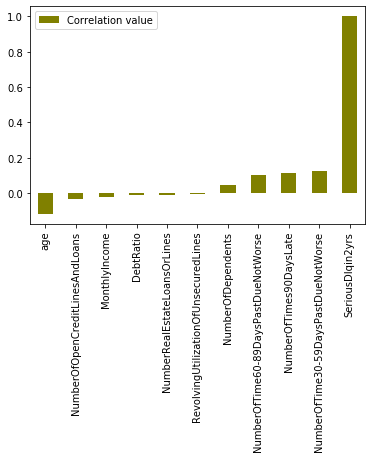

In [17]:
correlations.plot(kind="bar", color="olive")

We see that that the correlation values are a little less across all the variables. None of the variables have a correlation of more than 0.5. The variable _NumberOfTime30-59DaysPastDueNotWorse_ has the highest correlation with the dependent variable

### Correlation as heat map
We will check here the multi-collinearity between all the variable and understand which variable can be removed to avoid any multi-collinearity in the model

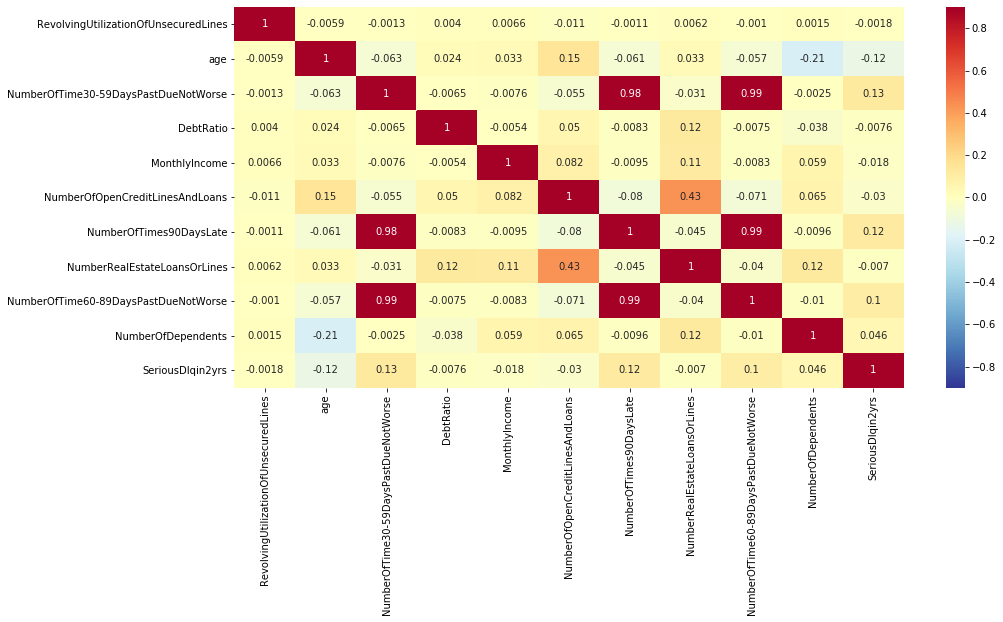

In [16]:
corr_ = df.corr()
fig= plt.figure(figsize=(15,7))
sns.heatmap(corr_, cmap = plt.cm.RdYlBu_r, vmin = -0.9, annot = True, vmax = 0.9)

Results : We see that variable; **NumberOfTime60-89DaysPastDueNotWorse**, **NumberOfTimes90DaysLate** & **NumberOfTime30-59DaysPastDueNotWorse** have a high correlation among themselves. To overcome the issue of multi-collinearity we can remove the two variables and keep only one of them. This is again a part of feature engineering. 

Now, why did I choose the variable **NumberOfTime60-89DaysPastDueNotWorse**, **NumberOfTimes90DaysLate** to be removed as firstly the variable _NumberofTime90DaysLate_ is a collection related variable which is like heavily used when a person is not able to pay back the loan and the collection (team which collects back money) reaches the customer to force him to pay or else a legal action is taken against him

In [20]:
#### Here we will drop variables to better our model
df           = df.drop(['NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'], axis=1)

#### Modelling

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['SeriousDlqin2yrs'], axis=1), df['SeriousDlqin2yrs'], test_size=0.2,random_state = 72)

### Oversampling and Undersampling
Since, we have already figured out that there is an unbalanced data, we will have to do a Oversampling and Undersampling. We will follow both the procedures and see which one we should follow to create a model

#### Oversmapling

In [22]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 8036
Before OverSampling, counts of label '0': 111964 

After OverSampling, the shape of train_X: (223928, 8)
After OverSampling, the shape of train_y: (223928,) 

After OverSampling, counts of label '1': 111964
After OverSampling, counts of label '0': 111964


### Function to measure the Model fit
Below is the function which we will use to measure the fitness of the model. The function contains metrics like Accuracy, Precision, Recall and F1 Score. It also calcualtes the GINI and AUC of the model and throws us the Feature Importance as per the respective model (only if the particular Machine Learning algorithm allows to do so)

In [50]:
def model_fit_reports(algo,X_,y_,performCV=True,printFeatureImportance=True, cv_folds=5):
    
    #Accuracy, Precision, Recall, F1 Score
    pred = algo.predict(X_)
    accu = accuracy_score(y_, pred)
    f1_  = f1_score(y_, pred)
    rec  = recall_score(y_, pred)
    prec = precision_score(y_, pred)

    
    #GINI & AUC
    fpr, tpr, thresholds = roc_curve(y_, pred)
    roc_auc = auc(fpr, tpr)
    Gini   = 2*roc_auc - 1   
    labels  = ['Accuracy','F1 Score', 'Recall', 'Precision', 'Gini', 'AUC']
    values  = [accu,f1_,rec,prec,Gini,roc_auc]
    
    all_    = pd.Series(values,labels)  
    print(all_)
    all_.plot(kind='bar', title='Model Fit Report')   


    if performCV:
        cv_score = cross_val_score(algo, X_, y_, cv=cv_folds, scoring='roc_auc')
        GINI     = 2 * cv_score -1
        print("AUC : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        print("GINI : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(GINI),np.std(GINI),np.min(GINI),np.max(GINI)))

    cols = list(X_.columns)
    if printFeatureImportance:
        feat_imp = pd.Series(algo.feature_importances_, cols).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')    
    
    return all_

### Developing our model with various Algorithms
We will be developing our model with various ML algorithms and compare it with Traditional Alogithms. Also, while it seems easy to tun these ML algos but it is quite tough optimize and tune such alogithms. In a classifier, we had to use some metrics on which basis we can tune and improve our classification. These metrics are:

* Precision
* Recall
* F1 Score
* GINI
* AUC

We will also run a CV to check if our results are consistent when measured on metrics like GINI or AUC

### Logistic Regression

In [23]:
regressor = LogisticRegression(random_state =2, solver='sag', max_iter = 10**2)
regressor.fit(X_train_res, y_train_res)

LogisticRegression(random_state=2, solver='sag')

#### Result on Train data

In [ ]:
train = model_fit_reports(algo =regressor ,X_ = X_train,y_ = y_train, performCV=True, printFeatureImportance=False, cv_folds=5)

#### Result on Test data

Accuracy     0.933667
F1 Score     0.001004
Recall       0.000503
Precision    0.500000
Gini Test    0.000467
AUC Test     0.500233
dtype: float64
CV Score : Mean - 0.5754241 | Std - 0.009694285 | Min - 0.5609097 | Max - 0.5864381


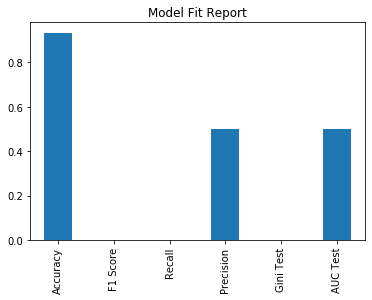

In [28]:
test  = model_fit_reports(algo =regressor ,X_ = X_test,y_ = y_test, performCV=True, printFeatureImportance=False, cv_folds=5)

### Random Forest

In [30]:
rfc = RandomForestClassifier(random_state=8, n_estimators=500)
rfc.fit(X_train_res, y_train_res)

RandomForestClassifier(n_estimators=500, random_state=8)

#### Result on the Train Data

Accuracy     0.998975
F1 Score     0.992395
Recall       0.998631
Precision    0.986236
Gini Test    0.997631
AUC Test     0.998815
dtype: float64
CV Score : Mean - 0.8207226 | Std - 0.006535456 | Min - 0.8088928 | Max - 0.828322


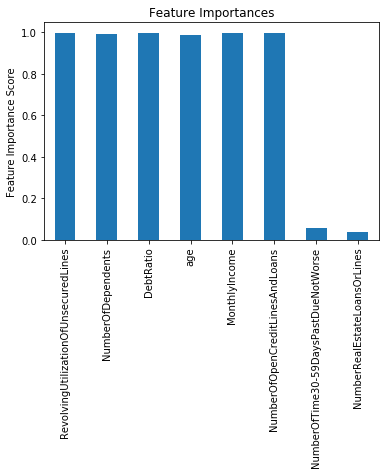

In [32]:
train = model_fit_reports(algo =rfc ,X_ = X_train,y_ = y_train, performCV=True, printFeatureImportance=True, cv_folds=5)

#### Result on the Test Data

Accuracy     0.880367
F1 Score     0.299707
Recall       0.385930
Precision    0.244976
Gini Test    0.301424
AUC Test     0.650712
dtype: float64
CV Score : Mean - 0.8099214 | Std - 0.005295745 | Min - 0.8044345 | Max - 0.8176102


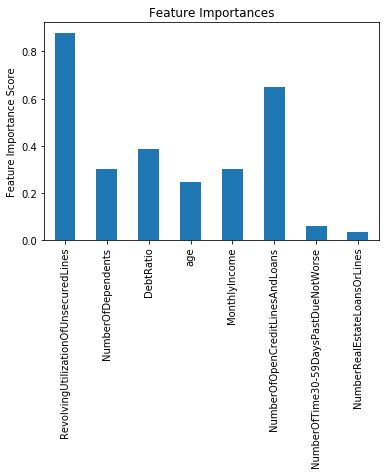

In [31]:
test = model_fit_reports(algo =rfc ,X_ = X_test,y_ = y_test, performCV=True, printFeatureImportance=True, cv_folds=5)

We see the Logistic Regression performs very poorly in comparison to Random Forest. Random Forest is performing decent when we see the Train Data Resuls but if you compare it with Test Data, it is a clear case of overfitting. We also know that Random Forest is prone to high variance or overfitting.

Now, we can't use Random Forest as our go to metric because of this reason. We have to go for boosting algorithms which are not prone to overfitting and uses a different technique

### Gradient Boosting

In [34]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train_res, y_train_res)

GradientBoostingClassifier()

Accuracy     0.852567
F1 Score     0.317386
Recall       0.511822
Precision    0.230008
Gini Test    0.388845
AUC Test     0.694422
dtype: float64
CV Score : Mean - 0.8383923 | Std - 0.004887897 | Min - 0.8296767 | Max - 0.8430249


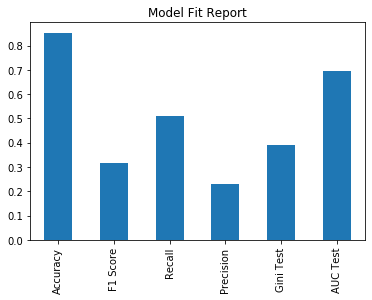

In [35]:
train = model_fit_reports(algo =gbc ,X_ = X_train,y_ = y_train, performCV=True, printFeatureImportance=False, cv_folds=5)

Accuracy     0.851667
F1 Score     0.313483
Recall       0.510553
Precision    0.226180
Gini Test    0.386454
AUC Test     0.693227
dtype: float64
AUC : Mean - 0.8290919 | Std - 0.007054309 | Min - 0.8202769 | Max - 0.8396676
GINI : Mean - 0.6581837 | Std - 0.01410862 | Min - 0.6405537 | Max - 0.6793352


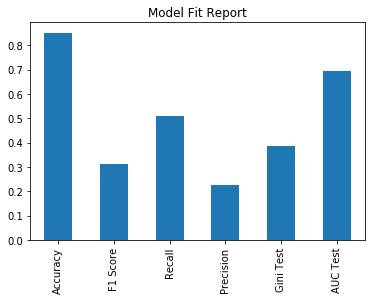

In [44]:
test = model_fit_reports(algo =gbc ,X_ = X_test,y_ = y_test, performCV=True, printFeatureImportance=False, cv_folds=5)

**As we can see the GINI of our test data is even less than 50%, we will have to tune it so that we attain a far better GINI on our Test data**

#### Tuning the Gradient Boosting parameters

We will be tuning the various hyperparameters of Gradient Boosting to improve our first cut results. The below image shows you what are the different pararmeters:

* **n_estimators** : The number of sequential trees to be modeled. Though GBM is fairly robust at higher number of trees but it can still overfit at a point. Hence, this should be tuned using CV for a particular learning rate.

* **max_depth** : This is the number of maximum depth of the tree. Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample

* **min_samples_split** : This is the minimum number of samples (or observations) which are required in a node to be considered for splitting.

* **min_samples_leaf** : This is the minimum samples (rows or observations) required in a terminal node or leaf

* **max_features** : The number of features to be considered while searching for the best split. A random selection is done when we fix the number of features to avoid any bias. Higher values can lead to over-fitting

* **subsample** : The fraction of observations to be selected for each tree. Selection is done by random sampling.

### Tuning n_estimators

In [39]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1    = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               min_samples_split=500,
                                                               min_samples_leaf=50,
                                                               max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
                                                               param_grid = param_test1, scoring='roc_auc',
                                                               n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train_res,y_train_res)

C:\Users\AJ\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  random_state=10,
                                                  subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'n_estimators': range(20, 81, 10)}, scoring='roc_auc')

In [41]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 80}, 0.9475181294437862)

### Tuning Max_depth & min_samples_split

In [45]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,400,600)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2.fit(X_train_res,y_train_res)


C:\Users\AJ\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  n_estimators=80,
                                                  random_state=10,
                                                  subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'max_depth': range(5, 16, 2),
                         'min_samples_split': range(200, 400, 600)},
             scoring='roc_auc')

In [46]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 15, 'min_samples_split': 200}, 0.9618341870406345)

### Tuning min_samples_split & min_samples_leaf

In [59]:
param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}

gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=15,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train_res,y_train_res)

C:\Users\AJ\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=15,
                                                  max_features='sqrt',
                                                  n_estimators=80,
                                                  random_state=10,
                                                  subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'min_samples_leaf': range(30, 71, 10),
                         'min_samples_split': range(1000, 2100, 200)},
             scoring='roc_auc')

In [60]:
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 30, 'min_samples_split': 1000}, 0.9538550674696118)

### Tuning max_features

In [61]:
param_test4 = {'max_features':range(7,20,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=15, min_samples_split=1000, min_samples_leaf=30, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train_res,y_train_res)

C:\Users\AJ\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=15,
                                                  min_samples_leaf=30,
                                                  min_samples_split=1000,
                                                  n_estimators=80,
                                                  random_state=10,
                                                  subsample=0.8),
             iid=False, n_jobs=4, param_grid={'max_features': range(7, 20, 2)},
             scoring='roc_auc')

In [62]:
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 7}, 0.956152009142316)

### Tuning subsample

In [38]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_depth= 15, min_samples_split= 1000, min_samples_leaf=30,max_features=7, random_state = 10),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train_res,y_train_res)

C:\Users\AJ\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=15, max_features=7,
                                                  min_samples_leaf=30,
                                                  min_samples_split=1000,
                                                  n_estimators=80,
                                                  random_state=10),
             iid=False, n_jobs=4,
             param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
             scoring='roc_auc')

In [39]:
gsearch5.best_params_, gsearch5.best_score_

({'subsample': 0.9}, 0.956814807747891)

#### Combining all the tuned parameter values and runnning them as a whole

In [45]:
gbc = GradientBoostingClassifier(n_estimators=80, max_depth= 15, min_samples_split= 1000, min_samples_leaf=30,subsample=0.9,max_features=7)
gbc.fit(X_train_res, y_train_res)

GradientBoostingClassifier(max_depth=15, max_features=7, min_samples_leaf=30,
                           min_samples_split=1000, n_estimators=80,
                           subsample=0.9)

Accuracy     0.892958
F1 Score     0.389061
Recall       0.508960
Precision    0.314882
Gini Test    0.429479
AUC Test     0.714739
dtype: float64
AUC : Mean - 0.8362434 | Std - 0.005063641 | Min - 0.8279042 | Max - 0.8408266
GINI : Mean - 0.6724868 | Std - 0.01012728 | Min - 0.6558084 | Max - 0.6816533


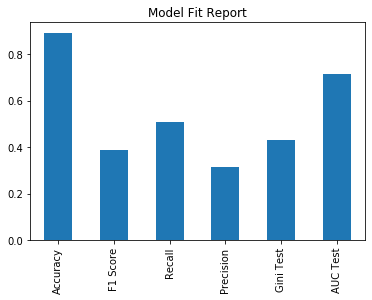

In [47]:
train = model_fit_reports(gbc,X_train,y_train,performCV=True,printFeatureImportance=False, cv_folds=5)

As you can see there is a lift in GINI by around 5% from tuning the hyperparameters. So, in this case we have been able to reduce the bias from the model by increasing the lift in GINI

Accuracy     0.875633
F1 Score     0.309713
Recall       0.420603
Precision    0.245095
Gini Test    0.328564
AUC Test     0.664282
dtype: float64
AUC : Mean - 0.8237081 | Std - 0.008120913 | Min - 0.8126759 | Max - 0.8370761
GINI : Mean - 0.6474162 | Std - 0.01624183 | Min - 0.6253519 | Max - 0.6741522


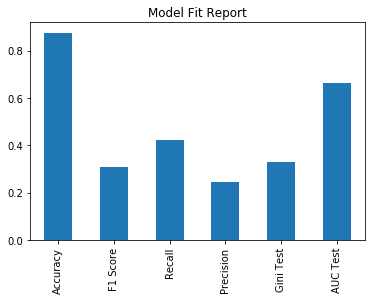

In [49]:
test = model_fit_reports(gbc,X_test,y_test,performCV=True,printFeatureImportance=False, cv_folds=5)

### XgBoost

In [51]:
xgb1 = XGBClassifier(
 learning_rate =0.001,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 reg_alpha = 0.1,
 scale_pos_weight=1,
 seed=27)

In [52]:
xgb1.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

Accuracy     0.870833
F1 Score     0.348575
Recall       0.516053
Precision    0.263168
Gini         0.412350
AUC          0.706175
dtype: float64
AUC : Mean - 0.837617 | Std - 0.005665312 | Min - 0.827034 | Max - 0.842943
GINI : Mean - 0.675234 | Std - 0.01133062 | Min - 0.654068 | Max - 0.685886


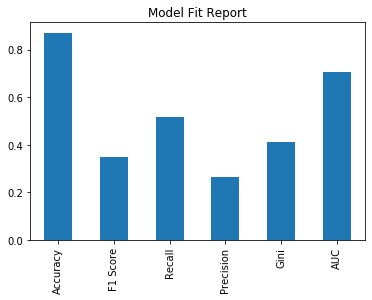

In [53]:
train = model_fit_reports(xgb1,X_train,y_train,performCV=True,printFeatureImportance=False, cv_folds=5)

Accuracy     0.862800
F1 Score     0.316733
Recall       0.479397
Precision    0.236490
Gini         0.369436
AUC          0.684718
dtype: float64
AUC : Mean - 0.8290391 | Std - 0.007461713 | Min - 0.8184969 | Max - 0.8409156
GINI : Mean - 0.6580781 | Std - 0.01492343 | Min - 0.6369939 | Max - 0.6818311


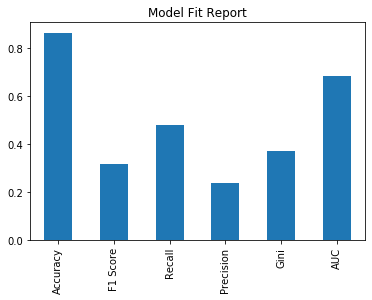

In [54]:
test = model_fit_reports(xgb1,X_test,y_test,performCV=True,printFeatureImportance=False, cv_folds=5)

#### Tuning XGboost

We will be tuning some of the hyperparameters of XgBoost:

* **max_depth**: The maximum depth of a tree
* **min_child_weight**: It is the minimum sum of weights of all observations required in a child
* **gamma**: A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split
* **subsample**: Denotes the fraction of observations to be randomly samples for each tree

In [69]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train_res, y_train_res)


C:\Users\AJ\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_method=

In [71]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 9, 'min_child_weight': 1}, 0.9630605327803566)

In [75]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train_res, y_train_res)

C:\Users\AJ\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_method=

In [76]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 9, 'min_child_weight': 1}, 0.9630605327803566)

In [77]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train_res, y_train_res)

C:\Users\AJ\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=9, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_method=

In [79]:
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.2}, 0.9625938874079267)

In [83]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=5,
 min_child_weight=1, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch6.fit(X_train_res, y_train_res)

C:\Users\AJ\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0.2,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_metho

In [84]:
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 0.1}, 0.9526962917223795)

### Deep Learning

KERAS is an Open Source Neural Network library written in Python that runs on top of Theano or Tensorflow. Keras doesn't handle low-level computation. Instead, it uses another library to do it, called the "Backend. So Keras is high-level API wrapper for the low-level API, capable of running on top of TensorFlow, CNTK, or Theano.

Keras High-Level API handles the way we make models, defining layers, or set up multiple input-output models. In this level, Keras also compiles our model with loss and optimizer functions, training process with fit function. Keras doesn't handle Low-Level API such as making the computational graph, making tensors or other variables because it has been handled by the "backend" engine.

We will be using deep learning to predict the default. Deep Learning an Advanced ML algorithm that uses the power of Neural Netowrks.

#### Run deep learning using keras

In [74]:
n_inputs = X_train_res.shape[1]

model = models.Sequential()
model.add(layers.Dense(16, activation ='relu', input_shape =(n_inputs, )))
model.add(layers.Dense(32,activation = 'relu'))
model.add(layers.Dense(1,activation ='sigmoid'))

In [75]:
model.compile(optimizer = 'rmsprop',
             loss= 'binary_crossentropy',
             metrics = ['accuracy'])

In [76]:
history = model.fit(X_train_res,
                   y_train_res,
                   epochs=150,
                   batch_size=512,
                   validation_data=(X_test,y_test))

Epoch 1/150
438/438 [==============================] - 7s 16ms/step - loss: 23.9219 - accuracy: 0.5029 - val_loss: 3.2329 - val_accuracy: 0.9059
Epoch 2/150
438/438 [==============================] - 6s 14ms/step - loss: 17.0568 - accuracy: 0.5037 - val_loss: 3.2020 - val_accuracy: 0.9339
Epoch 3/150
438/438 [==============================] - 5s 12ms/step - loss: 14.1422 - accuracy: 0.5083 - val_loss: 2.3281 - val_accuracy: 0.6461
Epoch 4/150
438/438 [==============================] - 5s 12ms/step - loss: 12.3889 - accuracy: 0.5093 - val_loss: 1.4228 - val_accuracy: 0.9340
Epoch 5/150
438/438 [==============================] - 5s 11ms/step - loss: 11.3979 - accuracy: 0.5106 - val_loss: 2.1502 - val_accuracy: 0.9340
Epoch 6/150
438/438 [==============================] - 5s 10ms/step - loss: 9.7676 - accuracy: 0.5108 - val_loss: 1.3342 - val_accuracy: 0.9340
Epoch 7/150
438/438 [==============================] - 5s 11ms/step - loss: 8.3068 - accuracy: 0.5128 - val_loss: 1.8436 - val_accu

#### Finding the Accuracy score on the Test Data

In [77]:
score = model.evaluate(X_test, y_test)

938/938 [==============================] - 1s 1ms/step - loss: 0.4182 - accuracy: 0.7934


In [78]:
#GINI & AUC 
pred  = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
print("The AUC of the Test model is ", roc_auc)
Gini   = 2*roc_auc - 1
print("The Gini of the Test model is ", Gini)

The AUC of the Test model is  0.8099560727593699
The Gini of the Test model is  0.6199121455187397


### ROC curve comparison on the Test Data

In [90]:
log_pred                   = regressor.predict(X_test)
rfc_pred                       = rfc.predict(X_test)
gbm_pred                       = gbc.predict(X_test)
xgb_pred                       = xgb1.predict(X_test)
deepl_pred                     = model.predict(X_test)

In [91]:
log_fpr, log_tpr, log_threshold   = roc_auc_score(y_test, log_pred)
rfc_fpr, rfc_tpr, rfc_threshold   = roc_auc_score(y_test, rfc_pred)
gbm_fpr, gbm_tpr, gbm_threshold   = roc_auc_score(y_test, gbm_pred)
xgb_fpr, xgb_tpr, xgb_threshold   = roc_auc_score(y_test, xgb_pred)
deepl_fpr, deepl_tpr, deepl_threshold   = roc_auc_score(y_test, deepl_pred)

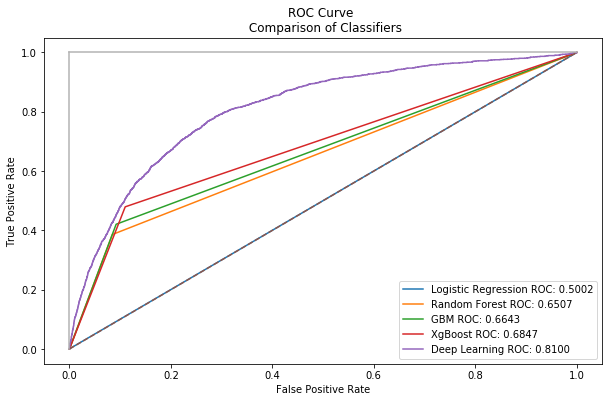

In [94]:
# Plot ROC curves
fig  = plt.figure(figsize=(10,6))
plt.title('ROC Curve \n Comparison of Classifiers')
plt.plot(log_fpr, log_tpr, label ='Logistic Regression AUC: {:.2f}'.format(roc_auc_score(y_test, log_pred)))
plt.plot(rfc_fpr, rfc_tpr, label ='Random Forest AUC: {:.f}'.format(roc_auc_score(y_test, rfc_pred)))
plt.plot(gbm_fpr, gbm_tpr, label ='GBM AUC: {:.2f}'.format(roc_auc_score(y_test, gbm_pred)))
plt.plot(xgb_fpr, xgb_tpr, label ='XgBoost AUC: {:.2f}'.format(roc_auc_score(y_test, xgb_pred)))
plt.plot(deepl_fpr, deepl_tpr, label ='Deep Learning AUC: {:.2f}'.format(roc_auc_score(y_test, deepl_pred)))

plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

**Result** : As we clearly see that the Deep Learning model works best on the Test data. It has a AUC score of around 81% which is a good classifer score for a first-second cut version. We can definitely improve a lot on this by tuning our keras model 

### Creating a Score from Probability

Next we have is how do we consume these probabilities. Since, predicting a default is under a Credit Risk team of a Bank, we need to provide these probabilities into a more consumable format which will be like a Score; something similar to a FICO Score or a CIBIL Score or a Experian Score. These are all the Buereau Score on which basis one can predict the likeliness of a person not paying back the loan.

We will also convert this probability into our internal Bank Score which will be used to give away loan once a customer applies for the same. This is called as an Application Score basis the information provided by the customer.

Some of the terms which will be used are:
* **Base Score**: This is the score on which we will start for each customer and then add/subtract points (absolute value) basis his probability to default (predicted). 

* **pdo**(Points to Double the odds): These are the points by which odds will be doubled. Odds here are (Good/Bads) ratio. For example, suppose at a score of 620, the odds ratio is 300/100 (3) and now if pdo is 100 then at a score of 720, the odds ratio will be 6.

* **Goods/Bads**: This is the initial Goods/Bads ratio to be taken


### Predict the probability for the full dataset with the Deep Learning Model

We will use the Deep Learning model to predict the probability for all the customer. We have also tested our model on the KPIs like GINI and AUC.

In [99]:
## Predict for the whole of the dataset
actual_   = df['SeriousDlqin2yrs']
df_new    = df.copy()
df_new    = df.drop(['SeriousDlqin2yrs'], axis=1)

In [100]:
pred_all  = model.predict(df_new)

In [105]:
fpr, tpr, thresholds = roc_curve(actual_, pred_all)
roc_auc = auc(fpr, tpr)
print("The AUC of the overall model is: {:.2f}".format(roc_auc))
Gini   = 2*roc_auc - 1
print("The Gini of the overall model is: {:.2f}".format(Gini))

The AUC of the overall model is: 0.81
The Gini of the overall model is: 0.63


### Initializing the Score variable to predict the score

In [106]:
## Convert the probability into a score
Base_Score = 600
pdo        = 120
Good_Bads  = 10

## Creating a function to calculate a Score
def score_(x, Offset, Factor):
    score_ = Offset - Factor * np.log(x)
    return score_

In [119]:
Factor          = pdo/np.log(2)
Offset          = Base_Score - Factor * np.log(Good_Bads)
Score_          = score_(pred_all, Offset=Offset, Factor=Factor)

In [120]:
Actual_vals      = pd.DataFrame(actual_).reset_index(drop=True)
Score            = pd.DataFrame(Score_)
pred_all         = pd.DataFrame(pred_all)
combine          = [Actual_vals,pred_all, Score]
combine_         = pd.concat(combine, axis=1)

In [121]:
combine_.columns  = ['Default', 'Predicted_prob', 'Risk_Score']

In [122]:
combine_              = combine_.replace([np.inf, -np.inf], np.nan)
combine_              = combine_[combine_.isna()==False]

#### We will cap the Score to 900 as some of the customers have a Probability of almost equal to zero which is there is almost no chance they will miss any loan payments

In [123]:
combine_.loc[(combine_.Risk_Score>900), ['Risk_Score']] = 899

Text(0.5, 1.0, 'Score Distribution')

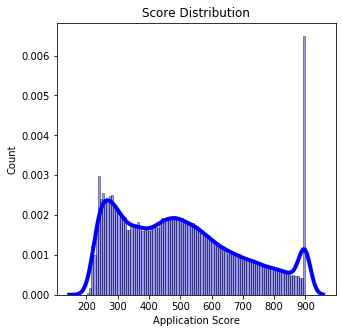

In [125]:
fig = plt.figure(figsize = (5,5))
ax = sns.distplot(combine_['Risk_Score'], hist=True, kde=True,
                        bins=100, color = 'blue',hist_kws={'edgecolor':'black'},
                         kde_kws={'linewidth': 4})

ax.set_xlabel("Application Score")
ax.set_ylabel("Count")
ax.set_title("Score Distribution")

### Create Deciles and check default rate by score bands

This is an idea exercise which every Credit Risk Manager does to understand if the scores created by him is rank ordering as per the actual defaults. We would create 10 groups in the Score we have created and then check the overall defauls and default rates in that particular Score Band

In [114]:
max_                         = max(combine_['Risk_Score'])
min_                         = min(combine_['Risk_Score'])
combine_['Score_decile']     = pd.cut(combine_['Risk_Score'], bins=[min_,300,415,490,555,600,690,730,max_],labels = [min_,300,415,490,555,600,690,730], include_lowest= True)

In [115]:
no_of_defaults                = combine_.groupby('Score_decile', as_index=False).agg({'Default':'sum', 'Predicted_prob':'count'})

In [116]:
no_of_defaults['default_rate'] = (no_of_defaults['Default']/no_of_defaults['Predicted_prob'] * 100)
no_of_defaults['Score_decile'] = round(no_of_defaults['Score_decile'],0)

In [117]:
no_of_defaults

,Score_decile,Default,Predicted_prob,default_rate
0,201.0,6039,27792,21.729275
1,300.0,2317,30193,7.673964
2,415.0,698,21017,3.321121
3,490.0,369,17761,2.077586
4,555.0,180,10311,1.745708
5,600.0,204,15445,1.320816
6,690.0,48,5385,0.891365
7,730.0,171,22096,0.773896


Text(0, 0.5, 'Default Rate')

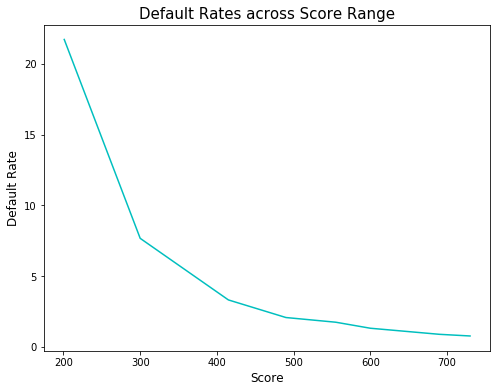

In [118]:
fig = plt.figure(figsize = (8,6))
plt.plot(no_of_defaults['Score_decile'], no_of_defaults['default_rate'], color = 'c')
plt.title("Default Rates across Score Range", fontsize = 15)
plt.xlabel("Score", fontsize = 12)
plt.ylabel("Default Rate", fontsize=12)

**Result**: As can be seen above, there is no rank ordering break; which is basically the Default rate for low score buckets is not lower than the Default rate for high score bucket

In [129]:
Final_data     = pd.concat([df,combine_], axis=1)

In [130]:
Final_data.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,SeriousDlqin2yrs,Default,Predicted_prob,Risk_Score
0,0.766127,45,2,0.802982,9120.0,13,6,2.0,1,1,0.624293,282.933289
1,0.957151,40,0,0.121876,2600.0,4,0,1.0,0,0,0.826314,234.397156
2,0.658180,38,1,0.085113,3042.0,2,0,0.0,0,0,0.703143,262.341797
3,0.233810,30,0,0.036050,3300.0,5,0,0.0,0,0,0.286822,417.581299
4,0.907239,49,1,0.024926,63588.0,7,1,0.0,0,0,0.130770,553.555908
